# 1. cats & dogs  데이터 보고 전처리하기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=[
        'train[:80%]',
        'train[80%:90%]',
        'train[90%:]'
    ],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

## Cats & Dogs 데이터 확인하기

In [4]:
# 데이터의 개수도 확인하기 
ds_train_len=tf.data.experimental.cardinality(ds_train)
ds_valid_len=tf.data.experimental.cardinality(ds_valid)
ds_test_len=tf.data.experimental.cardinality(ds_test)
print(ds_train_len)
print(ds_valid_len)
print(ds_test_len)

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)


In [6]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [7]:
ds_info.features["label"].num_classes

2

In [8]:
ds_info.features["label"].names

['cat', 'dog']

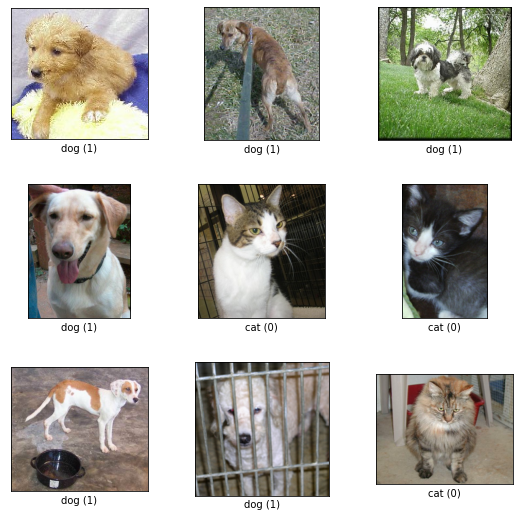

In [9]:
fig = tfds.show_examples(ds_train, ds_info)

## Cats & Dogs 데이터 전처리하기

In [10]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    return ds

In [12]:
ds_train = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=16)

In [13]:
ds_valid = apply_normalize_on_dataset(ds_valid, is_test=False, batch_size=16)

# 2. 모델 만들기

## 2-1 ResNet-34

In [14]:
# function for building ResNet Block

def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=0,
                    is_50=False,
                    flag_channel=64,
                    is_plain=False,
                   ):

    flag = flag_channel == channel
    bn = 1
    
    output = input_layer # 입력 레이어
    
    init_identity = output # 이전 블럭 정보를 init_identity에 저장한다. 

    if not is_50:
        for cnn_num in range(num_cnn):  # cnn_num
            
            identity = output
            
            if flag :  # flag가 true이면 기존 Block에 쌓고, stride를 2로 주어서 입력이미지 사이즈를 줄인다.  
                # 첫번째 Conv
                output = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(output)    
                
            else :  # flag가 false이면 새로운 Conv Block에 쌓는다.
                output = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(output)
                
            output = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(output)
            bn += 1
            output = keras.layers.Activation('relu')(output)
            
            
            # 두번째 Conv
            output = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2'
            )(output)
            output = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(output)
            bn += 1
            output = keras.layers.Activation('relu')(output)
                        
            if not is_plain :  # No shortcut connection 
              
                name=f'stage{block_num+2}_{cnn_num+1}_short'
                if flag :  # flag가 true이면 기존 Block에 쌓고, stride를 2로 주어서 입력이미지 사이즈를 줄인다.  
                    init_identity = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                else :
                    init_identity = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        strides=(2,2),
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                init_identity = keras.layers.BatchNormalization(
                    name=f'stage{block_num+2}_{cnn_num+1}_bn4'
                )(init_identity)

                flag=True
              
                if cnn_num == 0:
                    output = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([output, init_identity])
                    output = keras.layers.Activation('relu')(output)
                else :                       
                    output = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([output, identity])
                    output = keras.layers.Activation('relu')(output)
    else :

        for cnn_num in range(num_cnn):
            
            # 첫번째 Conv
            identity = output
            
            if flag :
                 output = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(output)    
                
            else :
                output = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(output)
                

            output = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(output)
            bn+=1
            output = keras.layers.Activation('relu')(output)
                        
            # 두번째 Conv
            output = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2',
            )(output)
            output = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(output)
            bn+=1
            output = keras.layers.Activation('relu')(output)
            
            # 세번째 Conv
            output = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv3'
            )(output)
            output = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(output)
            bn+=1
            output = keras.layers.Activation('relu')(output)
                                
            if not is_plain :
                
                if flag :   
                    init_identity = keras.layers.Conv2D(
                        filters=channel*4,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'stage{block_num+2}_{cnn_num+1}_short')(init_identity)

                else :
                    init_identity = keras.layers.Conv2D(
                        filters=channel*4,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        strides=(2,2),
                        name=f'stage{block_num+2}_{cnn_num+1}_short')(init_identity)

                init_identity = keras.layers.BatchNormalization(
                    name=f'stage{block_num+2}_{cnn_num+1}_bn4'
                )(init_identity)

                flag=True

                if cnn_num == 0:
                    output = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([output, init_identity])
                    output = keras.layers.Activation('relu')(output)
                else :
                    output = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([output, identity])
                    output = keras.layers.Activation('relu')(output)

    return output, flag_channel

## ResNet-34 블록 생성 확인하기


In [15]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))

output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        padding='same',
        strides=2,
        kernel_initializer='he_normal',
    )(resnet_input_layer)
output = keras.layers.BatchNormalization()(output)
output = keras.layers.Activation('relu')(output)
output = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2)(output)

resnet_block_output, flag_channel = build_resnet_block(output, 
                                                        channel=64, 
                                                        num_cnn=3, 
                                                        block_num=0)

resnet_block_output = keras.layers.AveragePooling2D(pool_size=(1,1))(resnet_block_output)
resnet_block_output = keras.layers.Flatten(name='flatten')(resnet_block_output)
resnet_block_output = keras.layers.Dense(10, activation='softmax', name='predictions')(resnet_block_output)

In [16]:
# 1개짜리 블록 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
# ResNet 모델 Build
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3, 4, 6, 3],
              channel_list=[64,128,256,512],
              num_classes=10,
              is_50=False,
              is_plain=False,):
    
    assert len(num_cnn_list) == len(channel_list) 
    
    input_layer = keras.layers.Input(shape=input_shape, name="input_layer")  
    output = input_layer 
    
    output = keras.layers.Conv2D(
        filters=channel_list[0],
        kernel_size=(7,7),
        padding='same',
        strides=2,
        kernel_initializer='he_normal',
    )(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPooling2D(
        pool_size=(2,2), 
        strides=2,
        name='stage2_0_maxpooling'
    )(output)
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output, cc = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_50=is_50,
            flag_channel=64,
            is_plain=is_plain
        )
        
    output = keras.layers.AveragePooling2D(pool_size=(1,1), name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='fc1000')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [18]:
# ResNet 34 모델 Build
resnet_34 = build_resnet()

resnet_34.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

## 2-2 ResNet-50 만들기

In [19]:
# ResNet-50 Build.
resnet_50 = build_resnet(
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64,128,256,512],
    is_50=True, 
)

resnet_50.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 16, 16, 64)   256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_59 (Activation)      (None, 16, 16, 64)   0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

## 모델 생성, 학습 및 비교 하기
- resnet 34 vs plain 34
- resnet 50 vs plain 50

In [20]:
def plot_loss_graph(res, pla, num) :
    plt.plot(res.history['loss'], 'r')
    plt.plot(pla.history['loss'], 'b')
    plt.title('Model training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['res'+str(num), 'pla'+str(num)], loc='upper left')
    plt.show()

In [21]:
def plot_acc_graph(res, pla, num) :
    plt.plot(res.history['val_accuracy'], 'r')
    plt.plot(pla.history['val_accuracy'], 'b')
    plt.title('Model validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['res'+str(num), 'pla'+str(num)], loc='upper left')
    plt.show()

## resnet34

In [22]:
INPUT_SHAPE = (224, 224, 3)

In [23]:
resnet_34 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=False,
    is_plain=False,)

resnet_34.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 112, 112, 64) 256         conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_124 (Activation)     (None, 112, 112, 64) 0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

In [25]:
BATCH_SIZE = 8
EPOCH = 5

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001), 
    metrics=['accuracy'],
)

res_history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
)

Epoch 1/5
2326/2326 [==============================] - 230s 99ms/step - loss: 1.2514 - accuracy: 0.5706 - val_loss: 0.9188 - val_accuracy: 0.6048
Epoch 2/5
2326/2326 [==============================] - 191s 82ms/step - loss: 0.5804 - accuracy: 0.7001 - val_loss: 0.5562 - val_accuracy: 0.7292
Epoch 3/5
2326/2326 [==============================] - 190s 82ms/step - loss: 0.5114 - accuracy: 0.7512 - val_loss: 0.4822 - val_accuracy: 0.7681
Epoch 4/5
2326/2326 [==============================] - 183s 79ms/step - loss: 0.5418 - accuracy: 0.7338 - val_loss: 0.4499 - val_accuracy: 0.7888
Epoch 5/5
2326/2326 [==============================] - 186s 80ms/step - loss: 0.4096 - accuracy: 0.8166 - val_loss: 0.4321 - val_accuracy: 0.8110


## resnet plain 34

In [26]:
plain_34 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=False,
    is_plain=True,)

In [28]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001), #, clipnorm=1.),
    metrics=['accuracy'],
)

pla_history_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
2326/2326 [==============================] - 181s 78ms/step - loss: 0.6825 - accuracy: 0.5805 - val_loss: 0.7689 - val_accuracy: 0.5703
Epoch 2/5
2326/2326 [==============================] - 115s 50ms/step - loss: 0.6560 - accuracy: 0.5994 - val_loss: 0.6826 - val_accuracy: 0.5311
Epoch 3/5
2326/2326 [==============================] - 116s 50ms/step - loss: 0.6948 - accuracy: 0.5308 - val_loss: 1.5102 - val_accuracy: 0.5097
Epoch 4/5
2326/2326 [==============================] - 112s 48ms/step - loss: 0.7009 - accuracy: 0.5116 - val_loss: 3.1166 - val_accuracy: 0.5251
Epoch 5/5
2326/2326 [==============================] - 119s 51ms/step - loss: 0.6977 - accuracy: 0.5158 - val_loss: 0.6955 - val_accuracy: 0.5331


## 비교하기

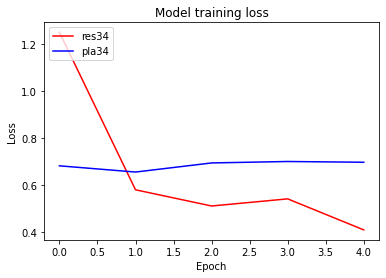

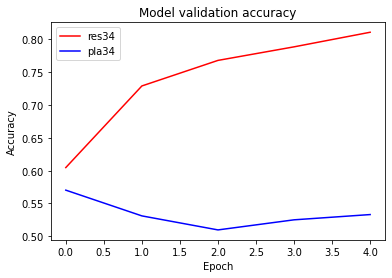

In [37]:
plot_loss_graph(res_history_34, pla_history_34, 34)
plot_acc_graph(res_history_34, pla_history_34, 34)

## resnet 50

In [38]:
resnet_50 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=True,
    is_plain=False,)

In [32]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001), 
    metrics=['accuracy'],
)

res_history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
2326/2326 [==============================] - 376s 162ms/step - loss: 2.0233 - accuracy: 0.5459 - val_loss: 2.7036 - val_accuracy: 0.5318
Epoch 2/5
2326/2326 [==============================] - 312s 134ms/step - loss: 0.7122 - accuracy: 0.6216 - val_loss: 0.7770 - val_accuracy: 0.5907
Epoch 3/5
2326/2326 [==============================] - 313s 135ms/step - loss: 0.6183 - accuracy: 0.6957 - val_loss: 0.5857 - val_accuracy: 0.7078
Epoch 4/5
2326/2326 [==============================] - 318s 137ms/step - loss: 0.6187 - accuracy: 0.7087 - val_loss: 1.9601 - val_accuracy: 0.6238
Epoch 5/5
2326/2326 [==============================] - 318s 137ms/step - loss: 0.6121 - accuracy: 0.7152 - val_loss: 1.0135 - val_accuracy: 0.6382


## resnet plain 50

In [33]:
plain_50 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=True,
    is_plain=True,)

In [35]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

pla_history_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
2326/2326 [==============================] - 195s 84ms/step - loss: 0.7375 - accuracy: 0.5105 - val_loss: 0.7314 - val_accuracy: 0.4844
Epoch 2/5
2326/2326 [==============================] - 141s 61ms/step - loss: 0.7208 - accuracy: 0.5076 - val_loss: 0.7037 - val_accuracy: 0.4883
Epoch 3/5
2326/2326 [==============================] - 145s 62ms/step - loss: 0.7172 - accuracy: 0.5117 - val_loss: 0.7105 - val_accuracy: 0.5228
Epoch 4/5
2326/2326 [==============================] - 148s 64ms/step - loss: 0.7126 - accuracy: 0.5147 - val_loss: 0.7855 - val_accuracy: 0.4849
Epoch 5/5
2326/2326 [==============================] - 146s 63ms/step - loss: 0.7068 - accuracy: 0.5139 - val_loss: 0.7115 - val_accuracy: 0.4911


## 비교하기

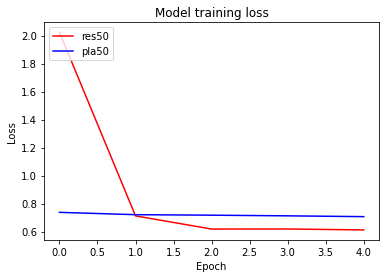

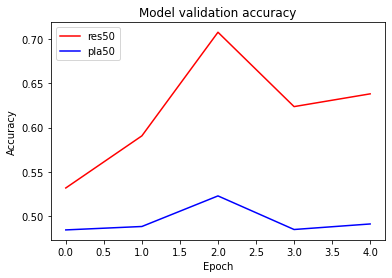

In [36]:
plot_loss_graph(res_history_50, pla_history_50, 50)
plot_acc_graph(res_history_50, pla_history_50, 50)